In [1]:
from metloom.pointdata import SnotelPointData
from metloom.variables import SnotelVariables

import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy.stats as stats
import numpy as np

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
fp = '../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json'
obj = gpd.read_file(fp)

# vrs = [
#     SnotelVariables.SWE,
#     SnotelVariables.SNOWDEPTH
# ]
# points = SnotelPointData.points_from_geometry(obj, vrs, snow_courses=True)
# df = points.to_dataframe()
df = gpd.read_file('../data/geodata/snowcourse_locs.geojson', driver='GeoJSON')

In [3]:
if os.path.exists('../data/snowdata/ucrb_snow_course_swe.nc'):
    ds = xr.open_dataset('../data/snowdata/ucrb_snow_course_swe.nc')
else:
    for i,snowcourse in enumerate(df['id'].unique()[63:]):
        name = df[df['id'] == snowcourse].name
        # first test to see if none is returned for the snowcourse
        test1 = SnotelPointData(snowcourse, name).get_snow_course_data(
            dt.datetime(1963,10, 1),
            dt.datetime(1968, 9, 30),
            [snotel_point.ALLOWED_VARIABLES.SWE])
        test2 = SnotelPointData(snowcourse, name).get_snow_course_data(
            dt.datetime(2018,10, 1),
            dt.datetime(2022, 9, 30),
            [snotel_point.ALLOWED_VARIABLES.SWE])
        if (test1 is None) or (test2 is None):
            pass
        else:
            data = SnotelPointData(snowcourse, name).get_snow_course_data(
                dt.datetime(1963,10, 1), 
                dt.datetime(2022, 9, 30),
                [snotel_point.ALLOWED_VARIABLES.SWE]).drop_duplicates()
            if i == 1000:
                ds = data.loc[~data.index.duplicated()].to_xarray()
                ds['datetime'] = pd.DatetimeIndex(ds['datetime'].values)
            else:
                tmp = data.loc[~data.index.duplicated()].to_xarray()
                tmp['datetime'] = pd.DatetimeIndex(tmp['datetime'].values)
                ds = xr.merge([ds, tmp])
            # # convert swe to mm
            ds['SWE'] = ds['SWE'] * 25.4
            # save ds['SWE'] to a netcdf file
            ds['SWE'].to_netcdf('../data/snowdata/ucrb_snow_course_swe.nc')

In [4]:
# for each year find the value closest to april 1
dates = []
for site in ds['site'].values:
    for year in range(1963,2022):
        month = 4
        day = 1
        val = ds['SWE'].sel(site=site).dropna(dim='datetime').sel(datetime=dt.date(year,month,day), method='nearest')
        if (abs(pd.to_datetime(val.datetime.values).to_pydatetime() - dt.datetime(year, month, day)).days < 14):
            dates.append(pd.to_datetime(val.datetime.values).to_pydatetime())
        


In [5]:
# remove duplicate values from dates
dates_list = list(set(dates))

In [6]:
ds_subset  = ds.sel(datetime=dates_list).where(ds.SWE>0)

In [7]:
pre_snow_course_data = ds_subset.where(ds_subset.datetime.dt.date<dt.date(2000,1,1), drop=True).sortby('datetime')
post_snow_course_data = ds_subset.where(ds_subset.datetime.dt.date>dt.date(2000,1,1), drop=True).sortby('datetime')

In [8]:
counts_pre = pre_snow_course_data.count(dim='datetime')
# drop sites with less than 30 observations
pre_snow_course_data_filtered = pre_snow_course_data.where(counts_pre >= 32, drop=True)

counts_post = post_snow_course_data.count(dim='datetime')
# drop sites with less than 17 observations
post_snow_course_data_filtered = post_snow_course_data.where((counts_post >= 19) & 
                                                             (post_snow_course_data.site.isin(pre_snow_course_data_filtered.site)), drop=True)

# filter pre course data to only include sites that have post course data
pre_snow_course_data_filtered = pre_snow_course_data_filtered.where(pre_snow_course_data_filtered.site.isin(post_snow_course_data_filtered.site), drop=True)                                                             

In [9]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630','09183500']) 
hcdn_basins = hcdn_basins[~bad_gages]
hcdn_basins = hcdn_basins.set_crs(32613,allow_override=True).to_crs(epsg=4326)

In [10]:
# find sites that have significant differences on pre and post snow course measurements
significant_decrease_sites = []
significant_increase_sites = []
no_significant_change = []
for site in pre_snow_course_data_filtered.site.values:
    pre = pre_snow_course_data_filtered.sel(site = site).SWE.dropna(dim='datetime').values
    post = post_snow_course_data_filtered.sel(site = site).SWE.dropna(dim='datetime').values
    if stats.ttest_ind(post,pre,equal_var=False,alternative='less').pvalue <= 0.05:
        significant_decrease_sites.append(site)
    elif stats.ttest_ind(post,pre,equal_var=False,alternative='greater').pvalue <= 0.05:
        significant_increase_sites.append(site)
    else:
        no_significant_change.append(site)

Text(0.5, 1.0, 'Snow Course Sites with Significant Change in March 1 SWE\nbetween Baseline and Millennium Drought Periods')

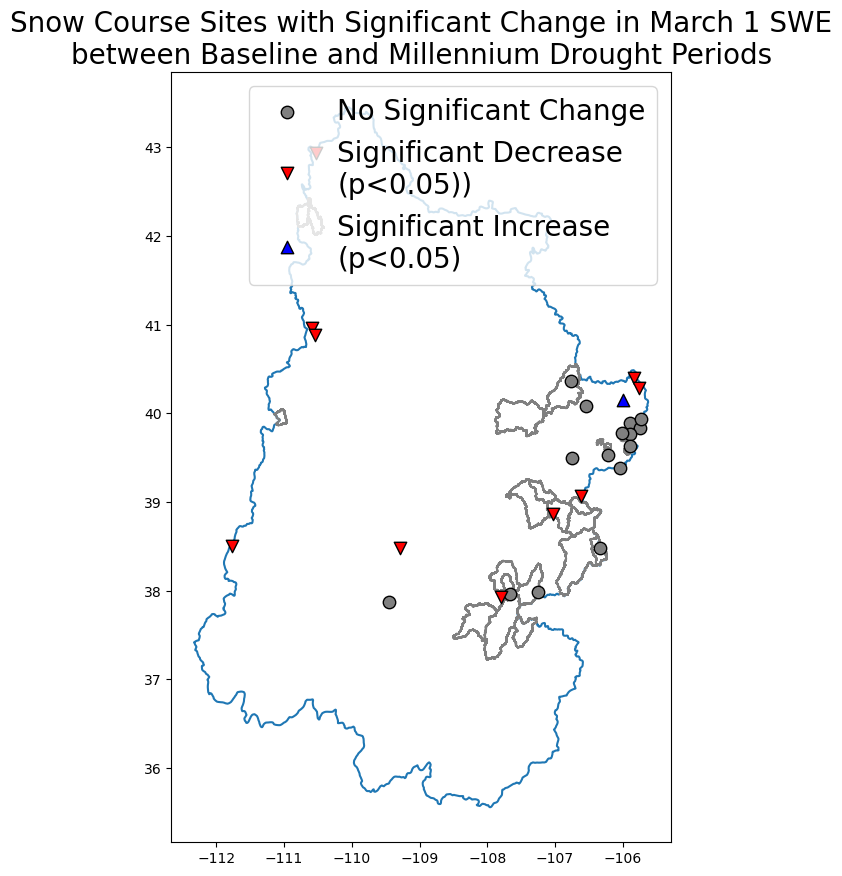

In [11]:
# plot where these changes are 
# plot the snow course locations
fig, ax = plt.subplots(figsize=(10,10))
obj.boundary.plot(ax=ax,zorder=0)
# plot the hcdn basin boundary
hcdn_basins.boundary.plot(ax=ax, color='grey', zorder=1)
# plot the snow course locations
df[df['id'].isin(no_significant_change)].plot(ax=ax, color='grey', markersize=80, ec='k', marker='o', label='No Significant Change')
df[df['id'].isin(significant_decrease_sites)].plot(ax=ax, color='red', markersize=80, ec='k', marker='v', label='Significant Decrease\n(p<0.05))')
df[df['id'].isin(significant_increase_sites)].plot(ax=ax, color='blue', markersize=80, ec='k', marker='^', label='Significant Increase\n(p<0.05)')
# add legend
ax.legend(loc='upper right', fontsize=20)
# add title
ax.set_title('Snow Course Sites with Significant Change in March 1 SWE\nbetween Baseline and Millennium Drought Periods', fontsize=20)


In [12]:
# analysis values
sites_in_analysis = df[(df['id'].isin(no_significant_change)) | (df['id'].isin(significant_increase_sites)) | (df['id'].isin(significant_decrease_sites))]
sites_in_analysis = sites_in_analysis.to_crs(32613)
hcdn_basins_32613 = hcdn_basins.to_crs(32613)


In [13]:
# find snow courses closest to the centroid of each basin
basin_snowcourses_nearest = gpd.sjoin_nearest(hcdn_basins_32613, sites_in_analysis, how='inner', max_distance=10000)
# drop duplicate index
basin_snowcourses_nearest = basin_snowcourses_nearest[~basin_snowcourses_nearest.index.duplicated(keep='last')]

In [14]:
large_spring_p_change = ['09081600','09352900','09107000','09110000','09112500','09124500','09146200','09165000','09361500','09304500','09147500','09119000','09132500']
small_spring_p_change = ['09066200', '09065500', '09047700', '09066300', '09035900']
large_spring_p_change_snowcourse = basin_snowcourses_nearest[basin_snowcourses_nearest.index.isin(large_spring_p_change)]
small_spring_p_change_snowcourse = basin_snowcourses_nearest[basin_snowcourses_nearest.index.isin(small_spring_p_change)]
# HCDN seasonal precipitation
hcdn_seasonal_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.sel(dim_1='ppt')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.rename({'__xarray_dataarray_variable__':'ppt','variable':'site_no'})
hcdn_seasonal_ppt = hcdn_seasonal_ppt.where(~hcdn_seasonal_ppt.site_no.isin(['09306242','09378170','09378630']),drop=True)
hcdn_seasonal_ppt['year'] = hcdn_seasonal_ppt.month.dt.year.where(hcdn_seasonal_ppt.month.dt.month<10, hcdn_seasonal_ppt.month.dt.year+1)

spring_p_change = hcdn_seasonal_ppt.sel(site_no=large_spring_p_change_snowcourse.index).where(hcdn_seasonal_ppt.month.dt.month==4,drop=True)
spring_p_change['month'] = spring_p_change.month.dt.year

large_spring_p_ds = ds_subset.sel(site=large_spring_p_change_snowcourse.id.values).sortby('datetime')
small_spring_p_ds = ds_subset.sel(site=small_spring_p_change_snowcourse.id.values).sortby('datetime')

In [15]:
# import annual streamflow totals
# Daily and annual HCDN streamflow and basin characteristics
hcdn_daily_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')
hcdn_amjj_q = xr.open_dataset('../data/streamflowdata/hcdn_amjj_q.nc')
hcdn_amjj_q['date'] = hcdn_amjj_q.date.dt.year
# filter out years with 0 streamflow
hcdn_amjj_q = hcdn_amjj_q.where(hcdn_amjj_q > 0, drop=True)
# drop out years below the 5th percentile
hcdn_amjj_q = hcdn_amjj_q.where(hcdn_amjj_q > hcdn_amjj_q.quantile(0.05), drop=True)
# rename q_mm_day to q_mm
hcdn_amjj_q = hcdn_amjj_q.rename({'q_mm_day': 'q_mm'})

hcdn_annual_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc').drop('dim_1')
replace_2022 = hcdn_daily_q.groupby('WY').sum().sel(WY=2022).q_mm_day.drop('WY')
replace_2022.name = 'q_mm'
for site in replace_2022.site_no:   
    hcdn_annual_q.loc[dict(WY=2022, site_no=site)] = replace_2022.loc[dict(site_no=site)]

In [16]:
hcdn_annual_q = hcdn_annual_q.sel(site_no=basin_snowcourses_nearest.index)
hcdn_springp_change_q = hcdn_annual_q.sel(site_no=spring_p_change.site_no.values)

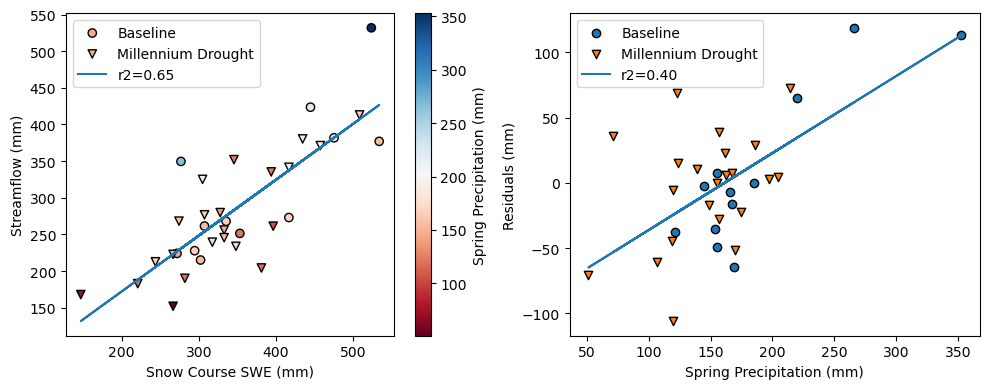

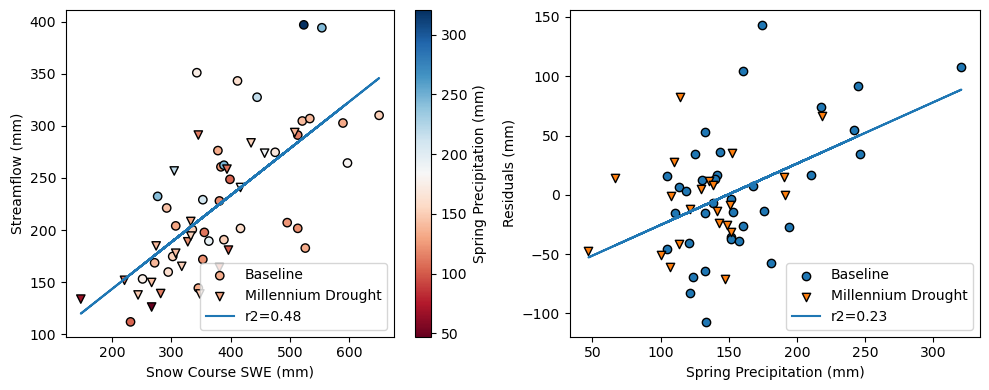

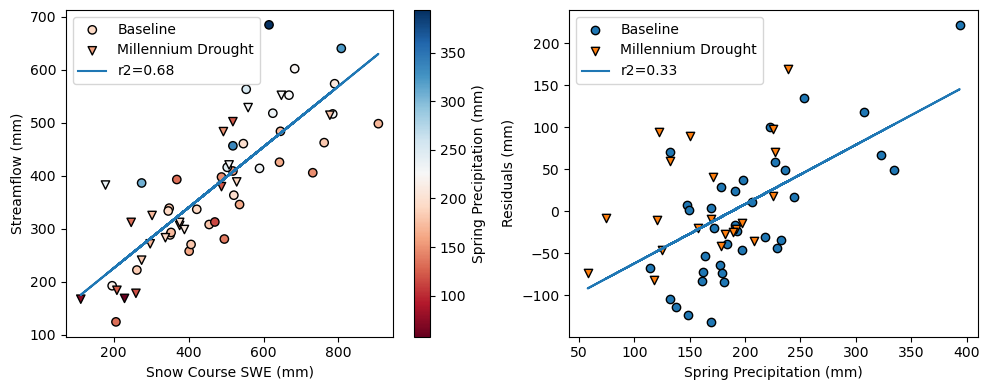

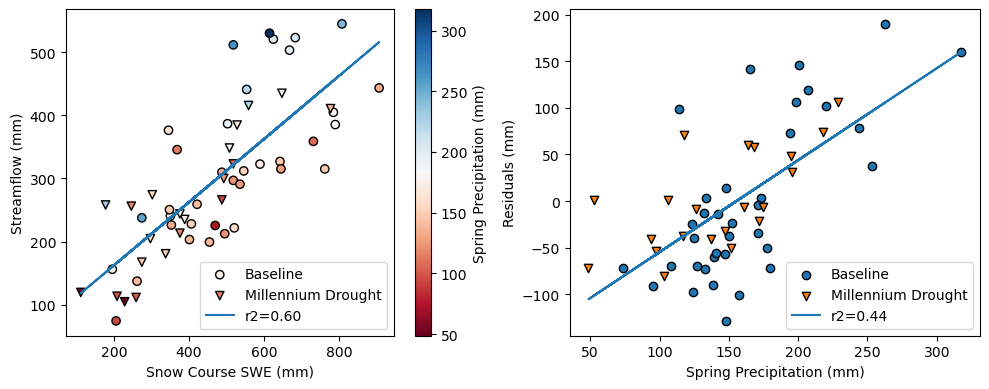

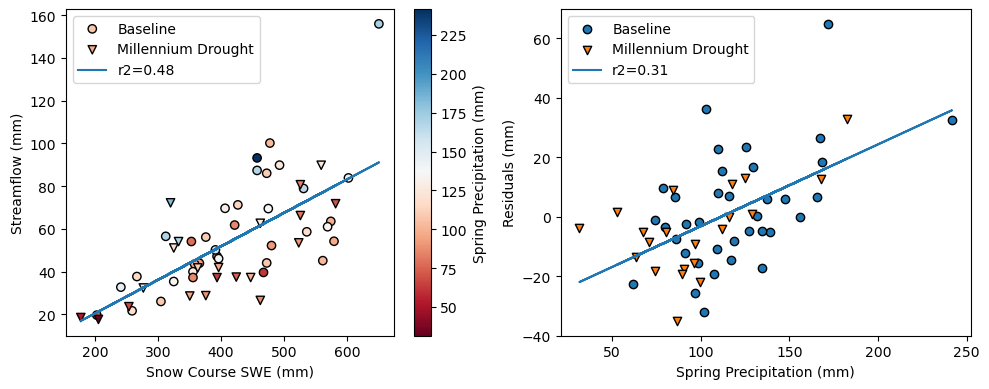

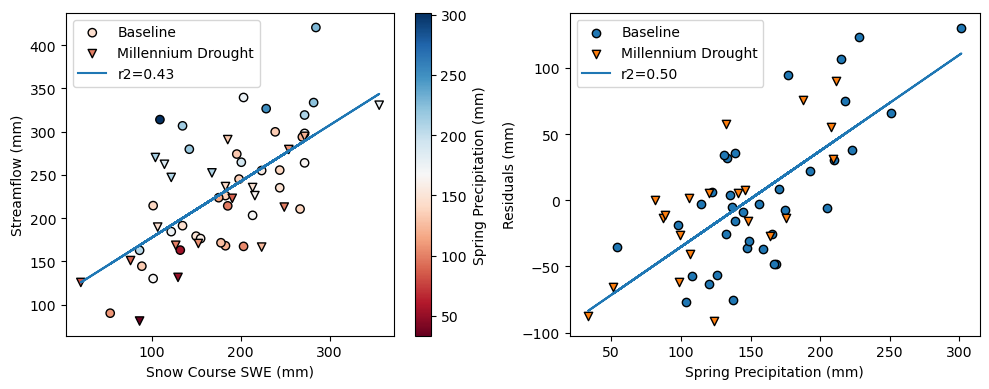

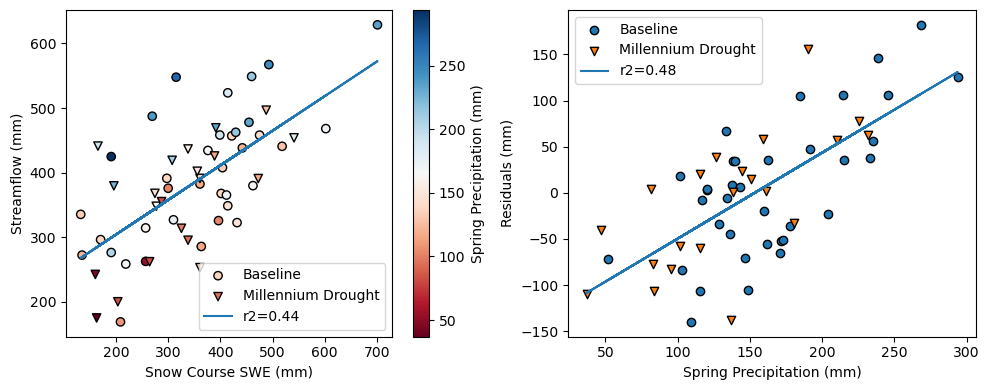

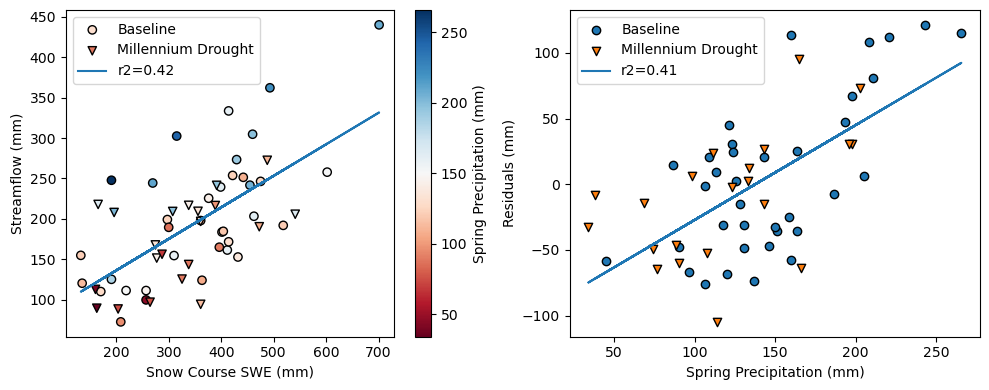

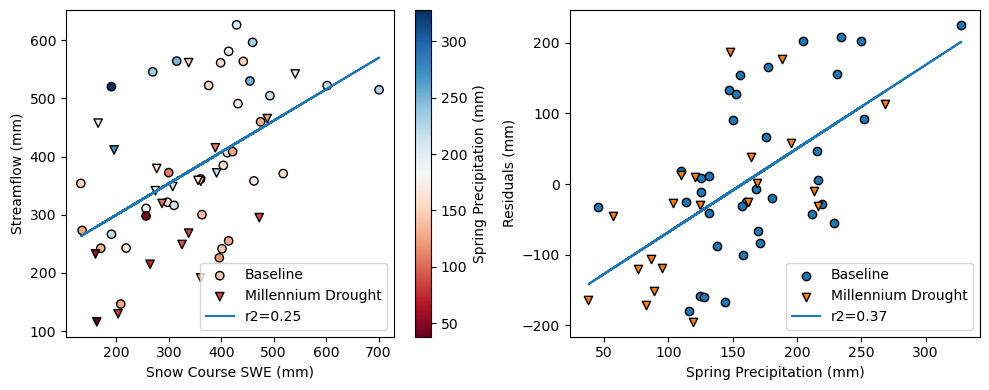

In [17]:
for i,site in enumerate(hcdn_springp_change_q.site_no.values):
    q = hcdn_springp_change_q.sel(site_no=site).q_mm.to_pandas()
    swe = large_spring_p_ds.SWE.isel(site=i).to_pandas().dropna()
    swe.index = swe.index.year
    springp = spring_p_change.sel(site_no=site).ppt.to_pandas()
    #combine these three into a temp dataframe
    temp = pd.concat([q,swe,springp],axis=1).loc[1964:].dropna()
    # set the columns to columns=['q','swe','springp']
    temp.columns = ['q','swe','springp']
    # temp = temp[temp['springp']!=temp['springp'].max()]
    fig, axs = plt.subplots(ncols=2, figsize=(10,4), tight_layout=True)
    im=axs[0].scatter(temp.swe,temp.q,c=temp.springp, cmap='RdBu', ec='k',s=1)
    axs[0].scatter(temp.swe.loc[:1999],temp.q.loc[:1999],c=temp.springp.loc[:1999], cmap='RdBu', ec='k', vmin=temp.springp.min(), vmax=temp.springp.max(), label='Baseline')
    im=axs[0].scatter(temp.swe.loc[2000:],temp.q.loc[2000:],c=temp.springp.loc[2000:], cmap='RdBu', ec='k', marker='v', vmin=temp.springp.min(), vmax=temp.springp.max(), label='Millennium Drought')
    # add a colorbar
    cbar = plt.colorbar(im,ax=axs[0])
    cbar.set_label('Spring Precipitation (mm)')
    axs[0].set_xlabel('Snow Course SWE (mm)')
    axs[0].set_ylabel('Streamflow (mm)')
    # add a best fit line using linregress and add the r2 value to the legend
    m, b, r, p, std_err = stats.linregress(temp.swe,temp.q)
    axs[0].plot(temp.swe, m*temp.swe + b, label=f'r2={r**2:.2f}')
    axs[0].legend()
    # calculate the residuals
    residuals = temp.q - (m*temp.swe + b)
    # plot the residuals against the spring precipitation
    axs[1].scatter(temp.springp.loc[:1999],residuals.loc[:1999], ec='k', label='Baseline')
    axs[1].scatter(temp.springp.loc[2000:],residuals.loc[2000:], ec='k', marker='v', label='Millennium Drought')
    # add a best fit line with r2 value in the legend using stats.linregress
    m, b, r, p, std_err = stats.linregress(temp.springp,residuals)
    axs[1].plot(temp.springp, m*temp.springp + b, label=f'r2={r**2:.2f}')
    axs[1].legend()
    axs[1].set_xlabel('Spring Precipitation (mm)')
    axs[1].set_ylabel('Residuals (mm)')



In [18]:
basin_snowcourses_nearest = basin_snowcourses_nearest[~basin_snowcourses_nearest.index.duplicated()]

In [19]:
pre_hcdn_annual_q = hcdn_annual_q.sel(WY=slice(1980,1999))
post_hcdn_annual_q = hcdn_annual_q.sel(WY=slice(2000,2022))

In [20]:
high_qswe_ttest_results = pd.DataFrame(index=basin_snowcourses_nearest.index, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
conf = 0.05    
    
axs = axs.flatten()                                                                       
for i,site in enumerate(basin_snowcourses_nearest.index):

    # pull in snow course data
    if not type(basin_snowcourses_nearest.loc[site]['id']) == str:
        pre_snow_data = pre_snow_course_data_filtered.sel(site=basin_snowcourses_nearest.loc[site]['id'].values[0]).dropna(dim='datetime').SWE.to_pandas()
        post_snow_data = post_snow_course_data_filtered.sel(site=basin_snowcourses_nearest.loc[site]['id'].values[0]).dropna(dim='datetime').SWE.to_pandas()
        # pull in streamflow data
        pre_q_data = hcdn_annual_q.sel(site_no=site).where(hcdn_annual_q.WY.isin(pre_snow_data.index.year), drop=True).q_mm
        post_q_data = hcdn_annual_q.sel(site_no=site).where(hcdn_annual_q.WY.isin(post_snow_data.index.year), drop=True).q_mm
        pre_q_data = pre_q_data.isel(site_no=0).to_pandas()
        post_q_data = post_q_data.isel(site_no=0).to_pandas()
    else:
        pre_snow_data = pre_snow_course_data_filtered.sel(site=basin_snowcourses_nearest.loc[site]['id']).dropna(dim='datetime').SWE.to_pandas().sort_index()
        post_snow_data = post_snow_course_data_filtered.sel(site=basin_snowcourses_nearest.loc[site]['id']).dropna(dim='datetime').SWE.to_pandas().sort_index()
        # pull in streamflow data
        pre_q_data = hcdn_annual_q.sel(site_no=site).where(hcdn_annual_q.WY.isin(pre_snow_data.index.year), drop=True).q_mm.to_pandas().sort_index()
        post_q_data = hcdn_annual_q.sel(site_no=site).where(hcdn_annual_q.WY.isin(post_snow_data.index.year), drop=True).q_mm.to_pandas().sort_index()

        # reset index to combine
        pre_snow_data.index = pre_snow_data.index.year
        post_snow_data.index = post_snow_data.index.year

        # concat pre snow and q
        pre_data = pd.concat([pre_snow_data,pre_q_data],axis=1)
        pre_data.columns = ['SWE','q_mm']
        pre_data = pre_data.dropna()
        # concat post snow and q
        post_data = pd.concat([post_snow_data,post_q_data],axis=1)
        post_data.columns = ['SWE','q_mm']
        post_data = post_data.dropna()
    if i == 4:
        pre_saved_for_plotting = pre_data
        post_saved_for_plotting = post_data
        site_saved_for_plotting = site
    # fig, ax = plt.subplots(figsize=(8,6)) 
    # #     # plot pre data
    # ax.scatter(pre_data['SWE'],pre_data['q_mm'])
    # # plot the best fit line
    # m, b = np.polyfit(pre_data['SWE'],pre_data['q_mm'], 1)  
    # ax.plot(pre_data['SWE'], m*pre_data['SWE'] + b, label="Baseline")

    # ax.scatter(post_data['SWE'],post_data['q_mm'])
    # # # plot the best fit line
    # m, b = np.polyfit(post_data['SWE'],post_data['q_mm'], 1)
    # ax.plot(post_data['SWE'], m*post_data['SWE'] + b,label=f"Millennium Drought")
    # if i ==0:
    #     ax.legend()
    # calculate q/swe ratio
    single_site_pre = (pre_data['q_mm']/pre_data['SWE'])
    single_site_post = (post_data['q_mm']/post_data['SWE'])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_qswe_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > 100:
        high_qswe_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        pvalue =  stats.ttest_ind(single_site_post, single_site_pre, equal_var=False)[1]
        high_qswe_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_qswe_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_qswe_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_qswe_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_qswe_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_qswe_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_qswe_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    high_qswe_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    high_qswe_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)
# add universal x-axis labels
fig.text(0.5, -0.02, 'SWE (mm)', ha='center', va='center', size=12)
# add universal y-axis labels
fig.text(-0.02, 0.5, 'Streamflow (mm)', ha='center', va='center', rotation='vertical', size=12)

Text(-0.02, 0.5, 'Streamflow (mm)')

Text(0.5, 1.0, 'UCRB Headwater Basin (Black Gore Creek)\nSnow Course and Annual Streamflow')

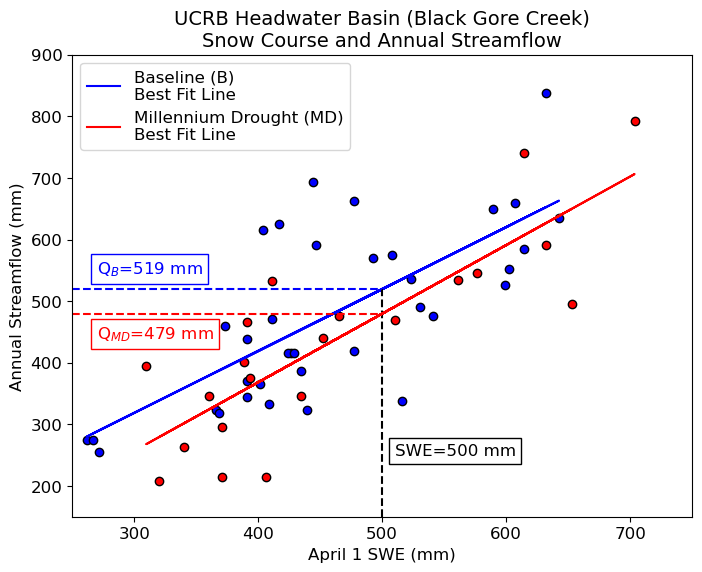

In [21]:
plt.figure(figsize=(8,6))
# plot pre_saved_for_plotting swe against q
plt.scatter(pre_saved_for_plotting['SWE'], 
            pre_saved_for_plotting['q_mm'],
            ec='k',
            color='b',)
# use linregress to add a best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(pre_saved_for_plotting['SWE'], pre_saved_for_plotting['q_mm'])
plt.plot(pre_saved_for_plotting['SWE'], 
        intercept + slope*pre_saved_for_plotting['SWE'], 
        color='blue', 
        label='Baseline (B)\nBest Fit Line')
# plot a vertical line at a point until it hits the best fit line
plt.plot([500, 500], [150,slope*500+intercept], color='k', linestyle='--')     
# add text in black saying SWE = 500 mm
plt.text(510, 250, 'SWE=500 mm', color='black', fontsize=12,bbox=dict(facecolor='white', alpha=1, ec='k'))
# plot a horizontal line at a point until it hits the best fit line
plt.plot([250, 500], [slope*500+intercept,slope*500+intercept], color='blue', linestyle='--') 
# add a text box below with the value of slope*500+intercept
plt.text(270, slope*500+intercept+25, 'Q$_B$=' +str(int(slope*500+intercept))+" mm", color='blue', fontsize=12,bbox=dict(facecolor='white', alpha=1, ec='blue'))   
# plot post_saved_for_plotting swe against q
plt.scatter(post_saved_for_plotting['SWE'], 
            post_saved_for_plotting['q_mm'],
            ec='k',
            color='r')
# use linregress to add a best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(post_saved_for_plotting['SWE'], post_saved_for_plotting['q_mm'])
plt.plot(post_saved_for_plotting['SWE'], 
         intercept + slope*post_saved_for_plotting['SWE'], 
         color='r', 
         label='Millennium Drought (MD)\nBest Fit Line')
# plot a horizontal line at a point until it hits the best fit line
plt.plot([250, 500], [slope*500+intercept,slope*500+intercept], color='red', linestyle='--')
# add a text box below with the value of slope*500+intercept
plt.text(270, slope*500+intercept-40, 'Q$_{MD}$=' + str(int(slope*500+intercept))+" mm", color='red', fontsize=12, bbox=dict(facecolor='white', alpha=1, ec='red'))
# add labels and legend    
plt.xlabel('April 1 SWE (mm)', size=12)
plt.ylabel('Annual Streamflow (mm)', size=12)
plt.ylim(150,900)
plt.xlim(250,750)
# increase tick label size
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.title('UCRB Headwater Basin (Black Gore Creek)\nSnow Course and Annual Streamflow', size=14)

In [22]:
import statsmodels.formula.api as sm

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


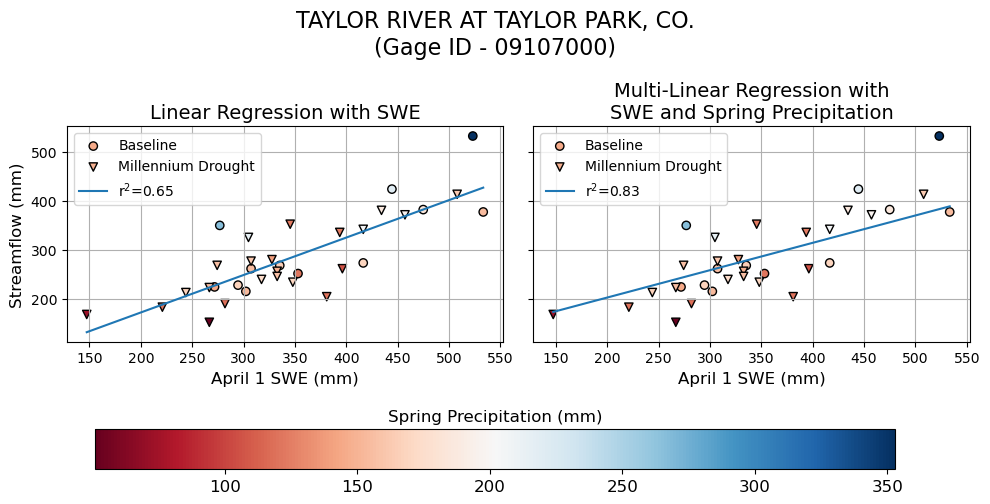

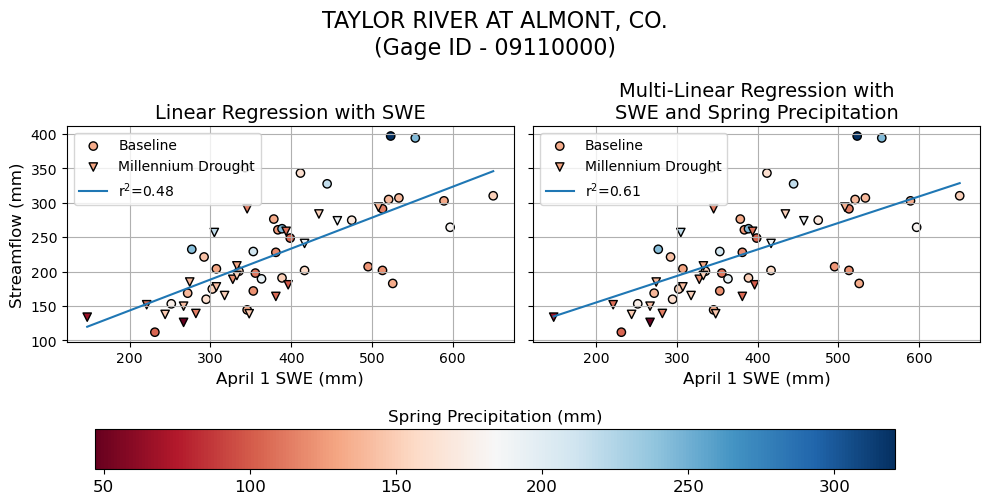

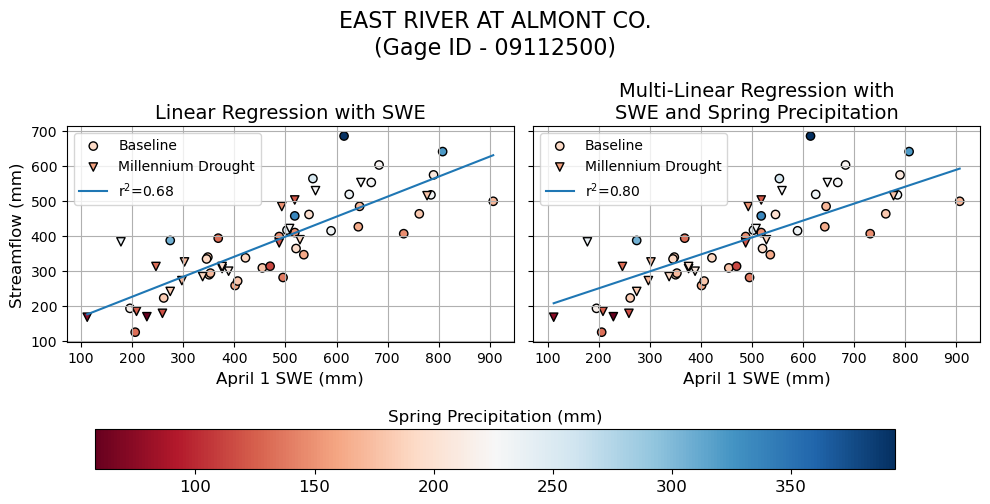

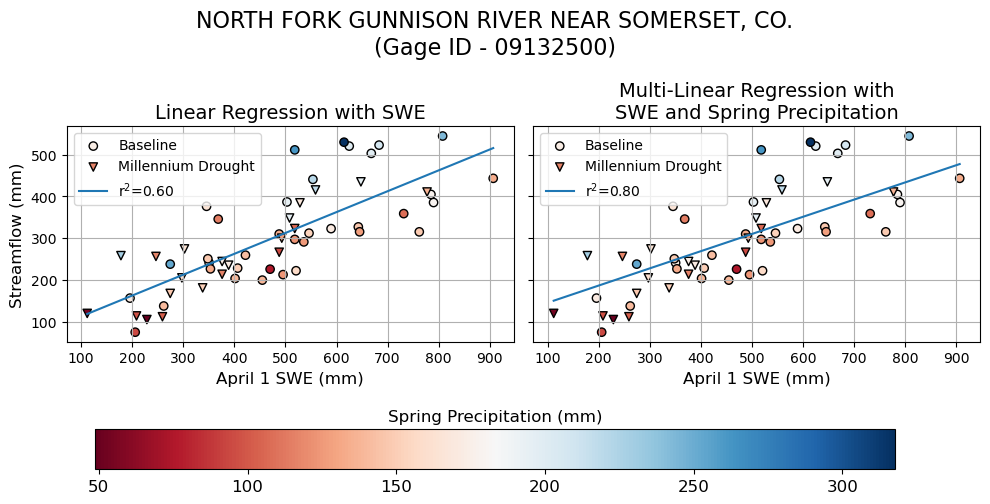

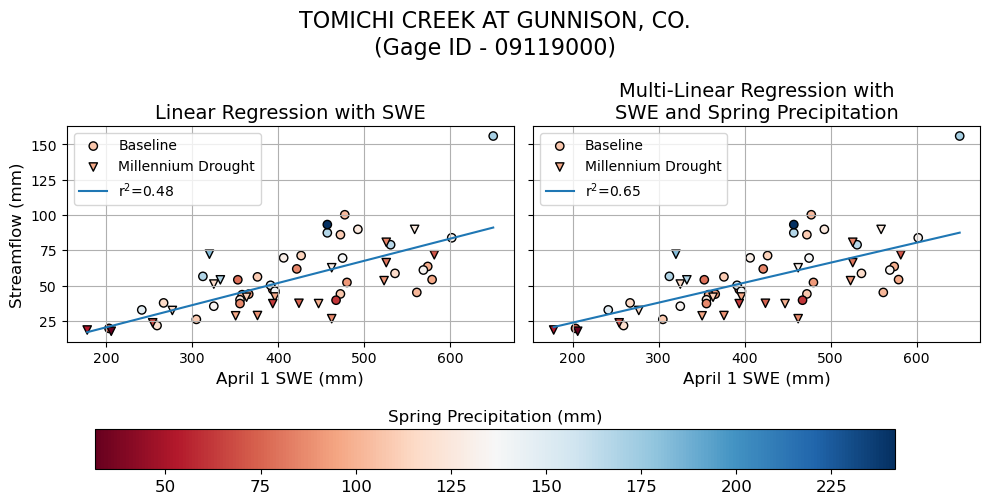

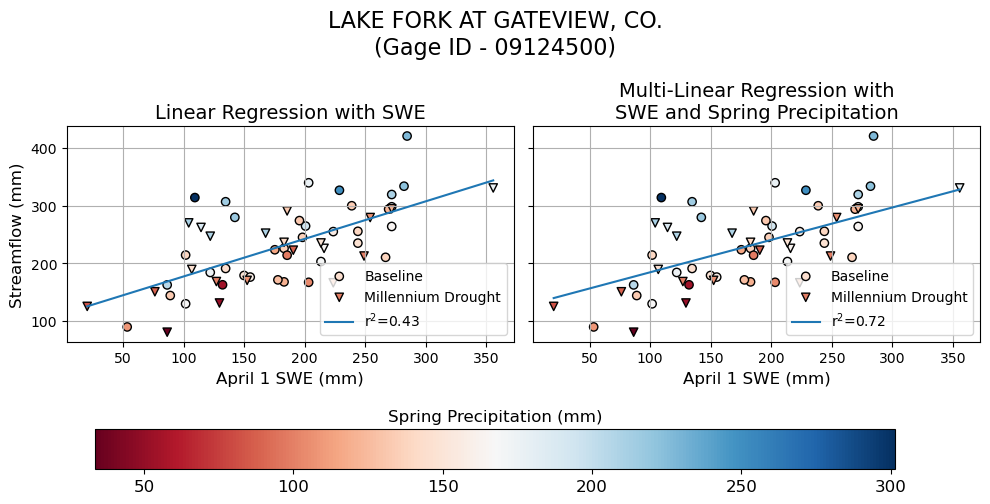

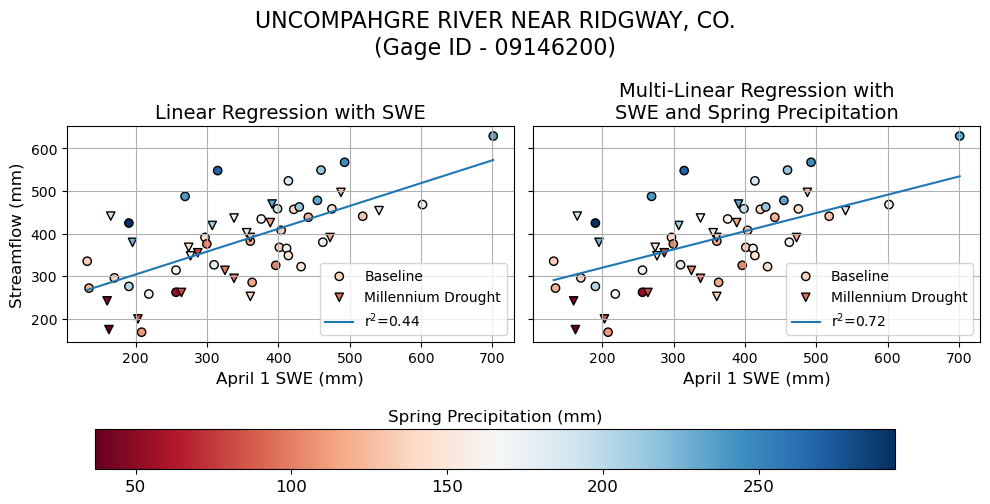

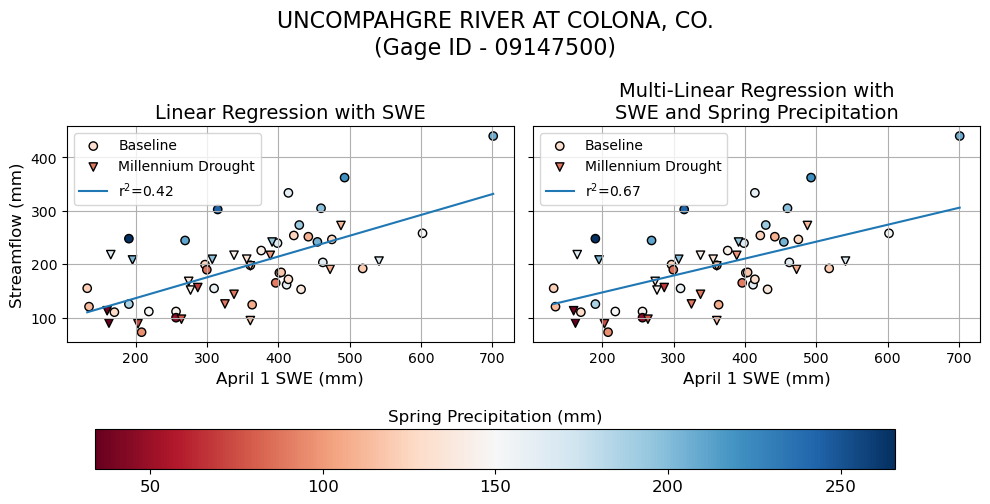

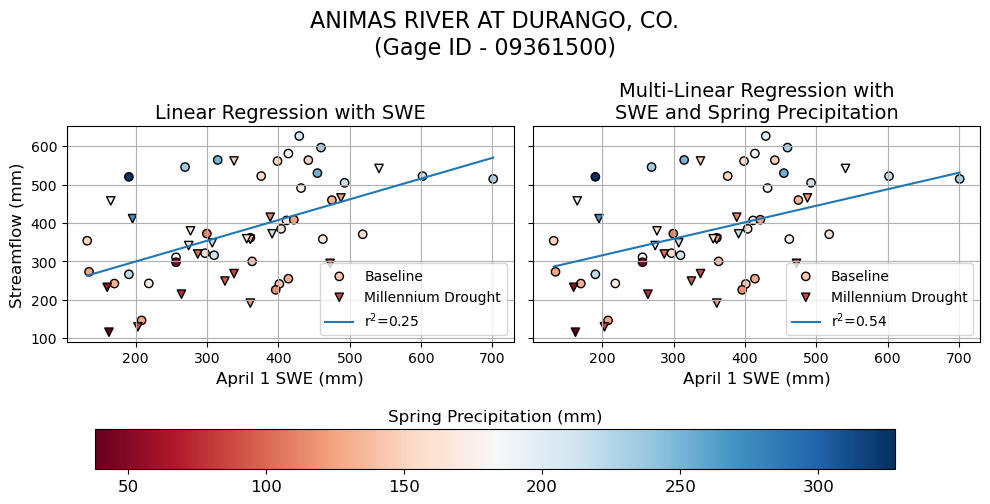

In [24]:
for i,site in enumerate(hcdn_springp_change_q.site_no.values):
    q = hcdn_springp_change_q.sel(site_no=site).q_mm.to_pandas()
    swe = large_spring_p_ds.SWE.isel(site=i).to_pandas().dropna()
    swe.index = swe.index.year
    springp = spring_p_change.sel(site_no=site).ppt.to_pandas()
    #combine these three into a temp dataframe
    temp = pd.concat([q,swe,springp],axis=1).loc[1964:].dropna()
    # set the columns to columns=['q','swe','springp']
    temp.columns = ['q','swe','springp']
    # temp = temp[temp['springp']!=temp['springp'].max()]
    fig, axs = plt.subplots(ncols=2,figsize=(10,4), tight_layout=True, sharey=True)
    im=axs[0].scatter(temp.swe,temp.q,c=temp.springp, cmap='RdBu', ec='k',s=1)
    axs[0].scatter(temp.swe.loc[:1999],temp.q.loc[:1999],c=temp.springp.loc[:1999], cmap='RdBu', ec='k', vmin=temp.springp.min(), vmax=temp.springp.max(), label='Baseline')
    im=axs[0].scatter(temp.swe.loc[2000:],temp.q.loc[2000:],c=temp.springp.loc[2000:], cmap='RdBu', ec='k', marker='v', vmin=temp.springp.min(), vmax=temp.springp.max(), label='Millennium Drought')
    # add a colorbar
    # cbar = plt.colorbar(im,ax=axs[0])
    # cbar.set_label('Spring Precipitation (mm)')
    # add a best fit line using linregress with swe as the independent variable and q as the dependent variable
    m,b,r,p,std = stats.linregress(temp.swe,temp.q)
    x = np.linspace(temp.swe.min(),temp.swe.max(),100)
    y = m*x + b
    axs[0].plot(x,y, label=f'r$^2$={r**2:.2f}')
    axs[0].legend()
    axs[0].set_xlabel('April 1 SWE (mm)', size=12)
    axs[0].set_ylabel('Streamflow (mm)',size=12)
    axs[0].set_title('Linear Regression with SWE',size=14)
    
    # run a multi linear regression using sm.OLS with q as the dependent variable and swe and springp as the independent variables
    im=axs[1].scatter(temp.swe,temp.q,c=temp.springp, cmap='RdBu', ec='k',s=1)
    axs[1].scatter(temp.swe.loc[:1999],temp.q.loc[:1999],c=temp.springp.loc[:1999], cmap='RdBu', ec='k', vmin=temp.springp.min(), vmax=temp.springp.max(), label='Baseline')
    im=axs[1].scatter(temp.swe.loc[2000:],temp.q.loc[2000:],c=temp.springp.loc[2000:], cmap='RdBu', ec='k', marker='v', vmin=temp.springp.min(), vmax=temp.springp.max(), label='Millennium Drought')
    # add a colorbar to span the whole figure on the top
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.1, -0.17, 0.8, 0.1])
    cbar = fig.colorbar(im, 
                 cax=cbar_ax, 
                 orientation='horizontal', 
                 )
    # increase hte size of the cbar title
    cbar.ax.set_title('Spring Precipitation (mm)', size=12)
    cbar.ax.tick_params(labelsize=12)                 

    axs[1].set_xlabel('April 1 SWE (mm)', size=12)
    # axs[1].set_ylabel('Streamflow (mm)')

    model = sm.ols(formula='q ~ swe + springp', data=temp)
    results = model.fit()
    m1 = results.params.swe
    m2 = results.params.springp
    b = results.params.Intercept
    r2 = results.rsquared
    # create a best fit line using the model results
    x = np.linspace(temp.swe.min(),temp.swe.max(),100)
    y = m1*x + m2*temp.springp.mean() + b

    # add a best fit line with the r2 value using these model results
    axs[1].plot(x,y, label=f'r$^2$={r2:.2f}')
    axs[1].legend()
    axs[1].set_title('Multi-Linear Regression with\nSWE and Spring Precipitation',size=14)
    for ax in axs:
        ax.grid(True, zorder=0)
    fig.suptitle(f"{hcdn_basins.loc[site]['name']}\n(Gage ID - {site})", size=16)


